In [18]:
from GPy import kern
from GPy.models import MRD #Bayesian Guassian Processes Latent Variable Model Mini Batch
import numpy as np
import GPy

In [7]:
def generate_high_dimensional_output(D1, D2, D3, s1, s2, s3, sS):
    S1 = np.hstack([s1, sS])
    S2 = np.hstack([sS])
    S3 = np.hstack([s1, s3, sS])
    Y1 = S1.dot(np.random.randn(S1.shape[1], D1))
    Y2 = S2.dot(np.random.randn(S2.shape[1], D2))
    Y3 = S3.dot(np.random.randn(S3.shape[1], D3))
    Y1 += .3 * np.random.randn(*Y1.shape)
    Y2 += .2 * np.random.randn(*Y2.shape)
    Y3 += .25 * np.random.randn(*Y3.shape)
    Y1 -= Y1.mean(0)
    Y2 -= Y2.mean(0)
    Y3 -= Y3.mean(0)
    Y1 /= Y1.std(0)
    Y2 /= Y2.std(0)
    Y3 /= Y3.std(0)
    return Y1, Y2, Y3, S1, S2, S3

In [11]:
D1, D2, D3, N, num_inducing, Q = 60, 20, 36, 60, 6, 5
plot_sim=1
np.random.seed(3000)
Q_signal=4
k = GPy.kern.Matern32(Q_signal, 1., lengthscale=(np.random.uniform(1, 6, Q_signal)), ARD=1)
for i in range(Q_signal):
    k += GPy.kern.PeriodicExponential(1, variance=1., active_dims=[i], period=3., lower=-2, upper=6)
    t = np.c_[[np.linspace(-1, 5, N) for _ in range(Q_signal)]].T
    K = k.K(t)
s2, s1, s3, sS = np.random.multivariate_normal(np.zeros(K.shape[0]), K, size=(4))[:, :, None]
Y1, Y2, Y3, S1, S2, S3 = generate_high_dimensional_output(D1, D2, D3, s1, s2, s3, sS)
slist = [sS, s1, s2, s3]
slist_names = ["sS", "s1", "s2", "s3"]
Ylist = [Y1, Y2, Y3]



In [22]:
k = kern.Linear(Q, ARD=True) + kern.White(Q, variance=1e-4)
inanlist = []
for Y in Ylist:
    inan = np.random.binomial(1, .6, size=Y.shape).astype(bool)
    inanlist.append(inan)
    Y[inan] = np.nan


In [14]:
m = MRD(Ylist, input_dim=Q, num_inducing=num_inducing,kernel=k, inference_method=None,
        initx="random", initz='permute')

In [15]:
m

manifold_relevance_determination.,value,constraints,priors
latent space.mean,"(60, 5)",,
latent space.variance,"(60, 5)",+ve,
inducing inputs,"(6, 5)",,
Y0.sum.linear.variances,"(5,)",+ve,
Y0.sum.white.variance,0.0001,+ve,
Y0.Gaussian_noise.variance,1.0,+ve,
Y1.sum.linear.variances,"(5,)",+ve,
Y1.sum.white.variance,0.0001,+ve,
Y1.Gaussian_noise.variance,1.0,+ve,
Y2.sum.linear.variances,"(5,)",+ve,


In [17]:
 m.optimize('bfgs', messages=1, max_iters=8e3, gtol=.1)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    01s14  0009   1.810714e+04   2.236950e+08 
    05s21  0045   2.310504e+03   5.531816e+02 
    16s37  0144   2.184207e+03   2.951617e+00 
    37s14  0329   2.175539e+03   1.116259e-01 
Runtime:     37s14
Optimization status: Converged



 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/__init__.py:1855: MatplotlibDeprecationWarning:The *left* kwarg to `bar` is deprecated use *x* instead. Support for *left* will be removed in Matplotlib 3.0


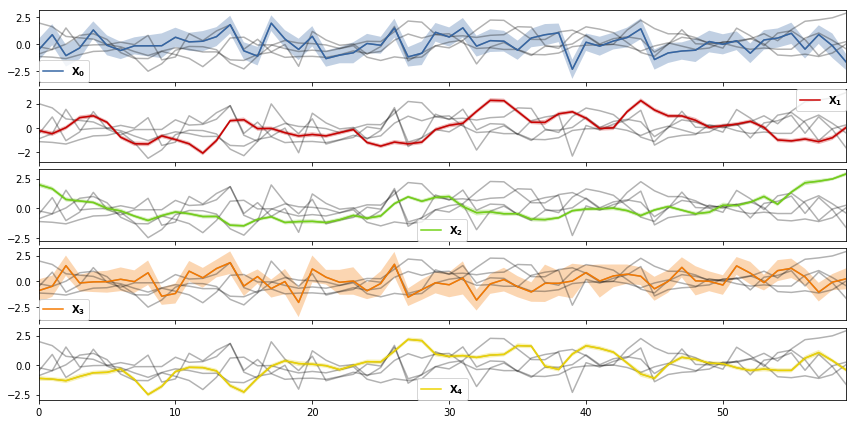

 /home/aneeqr/.local/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


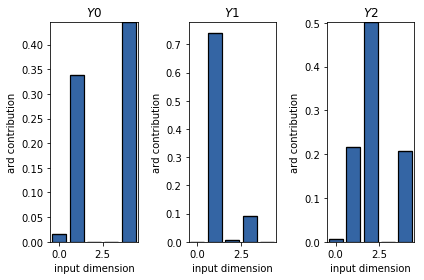

In [19]:
m.X.plot("MRD Latent Space 1D")
m.plot_scales()